In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
import tensorflow.keras as keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Embedding, LSTM, Dense

In [2]:
df = pd.read_csv("data/U.S._Chronic_Disease_Indicators__CDI_.csv")
# Keep only unique questions
df = df[~df.duplicated("Question", keep="first")][["Topic", "Question"]].reset_index(drop=True)
print(df.shape)
df.head()

(203, 2)


,Topic,Question
0,Alcohol,Amount of alcohol excise tax by beverage type ...
1,Alcohol,Amount of alcohol excise tax by beverage type ...
2,Alcohol,Amount of alcohol excise tax by beverage type ...
3,"Nutrition, Physical Activity, and Weight Status",Obesity among adults aged >= 18 years
4,Cardiovascular Disease,Hospitalization for heart failure among Medica...


In [3]:
topics = df["Topic"].value_counts()
topics

Nutrition, Physical Activity, and Weight Status    37
Cancer                                             20
Diabetes                                           20
Cardiovascular Disease                             18
Tobacco                                            16
Alcohol                                            16
Chronic Obstructive Pulmonary Disease              16
Overarching Conditions                             16
Arthritis                                          10
Oral Health                                         9
Asthma                                              9
Chronic Kidney Disease                              4
Older Adults                                        4
Mental Health                                       3
Reproductive Health                                 3
Disability                                          1
Immunization                                        1
Name: Topic, dtype: int64

In [4]:
df = df[df["Topic"].str.match("|".join(topics.nlargest(8).index.to_list()))].reset_index(drop=True)
print(df.shape)
df

(159, 2)


,Topic,Question
0,Alcohol,Amount of alcohol excise tax by beverage type ...
1,Alcohol,Amount of alcohol excise tax by beverage type ...
2,Alcohol,Amount of alcohol excise tax by beverage type ...
3,"Nutrition, Physical Activity, and Weight Status",Obesity among adults aged >= 18 years
4,Cardiovascular Disease,Hospitalization for heart failure among Medica...
...,...,...
154,"Nutrition, Physical Activity, and Weight Status",Median daily frequency of fruit consumption am...
155,"Nutrition, Physical Activity, and Weight Status",Presence of regulations pertaining to screen t...
156,"Nutrition, Physical Activity, and Weight Status",Farmers markets that accept Women and Infant C...
157,"Nutrition, Physical Activity, and Weight Status",Presence of regulations pertaining to serving ...


In [5]:
categories = list(df["Topic"].unique())
cat_to_label = {cat:i for i, cat in enumerate(categories)}
categories

['Alcohol',
 'Nutrition, Physical Activity, and Weight Status',
 'Cardiovascular Disease',
 'Diabetes',
 'Tobacco',
 'Overarching Conditions',
 'Chronic Obstructive Pulmonary Disease',
 'Cancer']

In [6]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(df["Question"])

In [7]:
X = tokenizer.texts_to_sequences(df["Question"])
X = pad_sequences(X, maxlen=df["Question"].apply(len).max())
X.shape

(159, 179)

In [8]:
y = df["Topic"].apply(lambda x: cat_to_label[x]).to_numpy()

In [9]:
x_train, x_test, y_train, y_test = train_test_split(X, y,
                                                  test_size=0.33)
del X, y
len(y_train), len(y_test)

(106, 53)

In [10]:
max_seq_len = df["Topic"].apply(len).max()
emb_dim = 100
cell_dim = 128
num_classes = len(categories)
vocab_size = len(tokenizer.word_index) + 1
penalty = 0.01

In [11]:
l2 = keras.regularizers.l2(penalty)
model = Sequential()
model.add(Embedding(vocab_size, emb_dim))
model.add(LSTM(cell_dim, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(num_classes, activation="softmax", kernel_regularizer=l2))

In [12]:
class saveBest(keras.callbacks.Callback):
    """Callback to save weights that maximize test accuracy"""
    def __init__(self):
        super(saveBest, self).__init__()
        self.best = {"Weights": None, "acc":float("-inf")}
        self.test_acc = []
    def on_epoch_end(self, epoch, logs=None):
        loss, acc = self.model.evaluate(x_test, y_test, verbose=False)
        if acc > self.best["acc"]:
            self.best["Weights"] = self.model.get_weights()
            self.best["acc"] = acc
        self.test_acc.append(acc)
save = saveBest()

In [13]:
model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [14]:
history = model.fit(x_train, y_train, epochs=250, batch_size=64, callbacks=[save])

Train on 106 samples
Epoch 1/250
106/106 [==============================] - 3s 31ms/sample - loss: 2.2290 - accuracy: 0.1604
Epoch 2/250
106/106 [==============================] - 1s 7ms/sample - loss: 2.2094 - accuracy: 0.2830
Epoch 3/250
106/106 [==============================] - 1s 7ms/sample - loss: 2.1918 - accuracy: 0.3113
Epoch 4/250
106/106 [==============================] - 1s 7ms/sample - loss: 2.1691 - accuracy: 0.3491
Epoch 5/250
106/106 [==============================] - 1s 6ms/sample - loss: 2.1380 - accuracy: 0.3302
Epoch 6/250
106/106 [==============================] - 1s 7ms/sample - loss: 2.1238 - accuracy: 0.2830
Epoch 7/250
106/106 [==============================] - 1s 7ms/sample - loss: 2.1033 - accuracy: 0.2358
Epoch 8/250
106/106 [==============================] - 1s 6ms/sample - loss: 2.0521 - accuracy: 0.2264
Epoch 9/250
106/106 [==============================] - 1s 7ms/sample - loss: 2.0470 - accuracy: 0.2264
Epoch 10/250
106/106 [=============================

106/106 [==============================] - 1s 7ms/sample - loss: 0.1845 - accuracy: 0.9906
Epoch 80/250
106/106 [==============================] - 1s 7ms/sample - loss: 0.1767 - accuracy: 1.0000
Epoch 81/250
106/106 [==============================] - 1s 7ms/sample - loss: 0.1754 - accuracy: 1.0000
Epoch 82/250
106/106 [==============================] - 1s 7ms/sample - loss: 0.1794 - accuracy: 1.0000
Epoch 83/250
106/106 [==============================] - 1s 7ms/sample - loss: 0.1673 - accuracy: 1.0000
Epoch 84/250
106/106 [==============================] - 1s 7ms/sample - loss: 0.1696 - accuracy: 1.0000
Epoch 85/250
106/106 [==============================] - 1s 7ms/sample - loss: 0.1670 - accuracy: 1.0000
Epoch 86/250
106/106 [==============================] - 1s 7ms/sample - loss: 0.1578 - accuracy: 1.0000
Epoch 87/250
106/106 [==============================] - 1s 6ms/sample - loss: 0.1629 - accuracy: 1.0000
Epoch 88/250
106/106 [==============================] - 1s 7ms/sample - loss:

106/106 [==============================] - 1s 7ms/sample - loss: 0.0960 - accuracy: 1.0000
Epoch 158/250
106/106 [==============================] - 1s 7ms/sample - loss: 0.1091 - accuracy: 0.9906
Epoch 159/250
106/106 [==============================] - 1s 8ms/sample - loss: 0.0983 - accuracy: 1.0000
Epoch 160/250
106/106 [==============================] - 1s 7ms/sample - loss: 0.0960 - accuracy: 1.0000
Epoch 161/250
106/106 [==============================] - 1s 7ms/sample - loss: 0.0973 - accuracy: 1.0000
Epoch 162/250
106/106 [==============================] - 1s 7ms/sample - loss: 0.0990 - accuracy: 1.0000
Epoch 163/250
106/106 [==============================] - 1s 8ms/sample - loss: 0.0971 - accuracy: 1.0000
Epoch 164/250
106/106 [==============================] - 1s 9ms/sample - loss: 0.0951 - accuracy: 1.0000
Epoch 165/250
106/106 [==============================] - 1s 8ms/sample - loss: 0.0954 - accuracy: 1.0000
Epoch 166/250
106/106 [==============================] - 1s 8ms/sampl

106/106 [==============================] - 1s 6ms/sample - loss: 0.0738 - accuracy: 1.0000
Epoch 236/250
106/106 [==============================] - 1s 6ms/sample - loss: 0.0757 - accuracy: 1.0000
Epoch 237/250
106/106 [==============================] - 1s 7ms/sample - loss: 0.0733 - accuracy: 1.0000
Epoch 238/250
106/106 [==============================] - 1s 7ms/sample - loss: 0.0709 - accuracy: 1.0000
Epoch 239/250
106/106 [==============================] - 1s 7ms/sample - loss: 0.0726 - accuracy: 1.0000
Epoch 240/250
106/106 [==============================] - 1s 6ms/sample - loss: 0.0722 - accuracy: 1.0000
Epoch 241/250
106/106 [==============================] - 1s 7ms/sample - loss: 0.0715 - accuracy: 1.0000
Epoch 242/250
106/106 [==============================] - 1s 7ms/sample - loss: 0.0713 - accuracy: 1.0000
Epoch 243/250
106/106 [==============================] - 1s 6ms/sample - loss: 0.0727 - accuracy: 1.0000
Epoch 244/250
106/106 [==============================] - 1s 6ms/sampl

In [15]:
print("Using weights after full training:")
model.evaluate(x_test, y_test)
print("Using best weights from tf2.0 callback:")
model.set_weights(save.best["Weights"])
model.evaluate(x_test, y_test)

Using weights after full training:
53/53 [==============================] - 0s 2ms/sample - loss: 0.7116 - accuracy: 0.8113
Using best weights from tf2.0 callback:
53/53 [==============================] - 0s 2ms/sample - loss: 0.7324 - accuracy: 0.8302


[0.7323829250515632, 0.8301887]

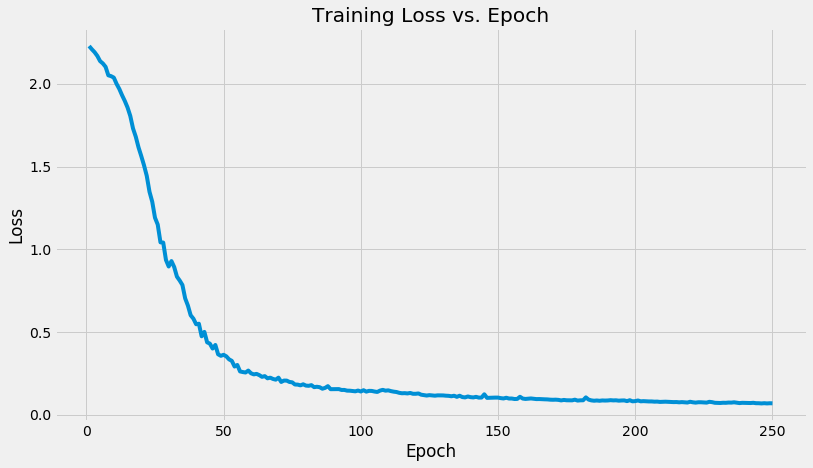

In [16]:
losses = history.history["loss"]
fig = plt.figure(figsize=(12, 7))
plt.plot(range(1, len(losses)+1), losses)
plt.ylabel("Loss")
plt.xlabel("Epoch")
plt.title("Training Loss vs. Epoch")
plt.gcf().subplots_adjust(bottom=0.1)
plt.savefig('plots/LSTM_training_loss.png')

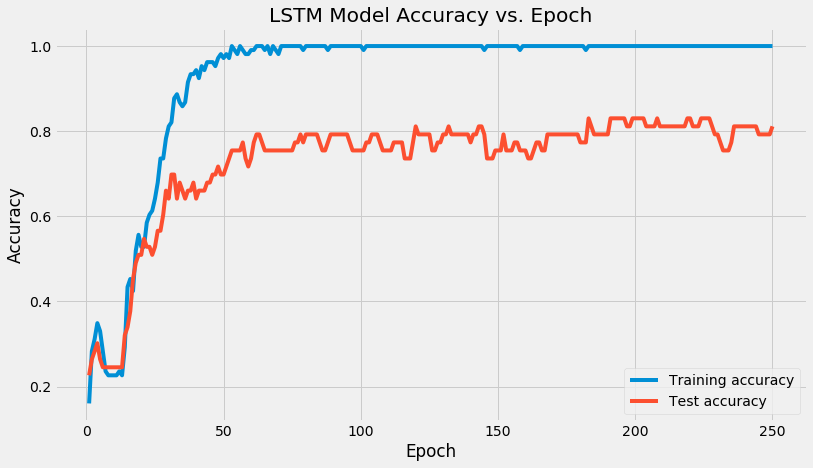

In [17]:
train_acc = history.history["accuracy"]
test_acc = save.test_acc
fig = plt.figure(figsize=(12, 7))
plt.plot(range(1, len(train_acc)+1), train_acc, label="Training accuracy")
plt.plot(range(1, len(test_acc)+1), test_acc, label="Test accuracy")
plt.ylabel("Accuracy")
plt.xlabel("Epoch")
plt.title("LSTM Model Accuracy vs. Epoch")
plt.legend()
plt.gcf().subplots_adjust(bottom=0.1)
plt.savefig('plots/LSTM_accuracy.png')

In [18]:
label_to_cat = {label:cat for cat, label in cat_to_label.items()}
predicted = model.predict(x_test).argmax(axis=1)
cm = confusion_matrix(y_test, predicted)
df_matrix = pd.DataFrame(cm, index=[cat for cat in categories],
             columns=["Predicted %s" % cat for cat in categories])
df_matrix

,Predicted Alcohol,"Predicted Nutrition, Physical Activity, and Weight Status",Predicted Cardiovascular Disease,Predicted Diabetes,Predicted Tobacco,Predicted Overarching Conditions,Predicted Chronic Obstructive Pulmonary Disease,Predicted Cancer
Alcohol,5,0,0,0,0,0,0,0
"Nutrition, Physical Activity, and Weight Status",0,11,0,1,0,1,0,0
Cardiovascular Disease,0,0,5,0,0,0,0,0
Diabetes,0,0,1,5,0,0,0,0
Tobacco,2,0,0,0,4,0,0,1
Overarching Conditions,0,2,0,0,0,3,0,0
Chronic Obstructive Pulmonary Disease,0,0,0,0,0,0,7,0
Cancer,0,0,0,0,0,1,0,4


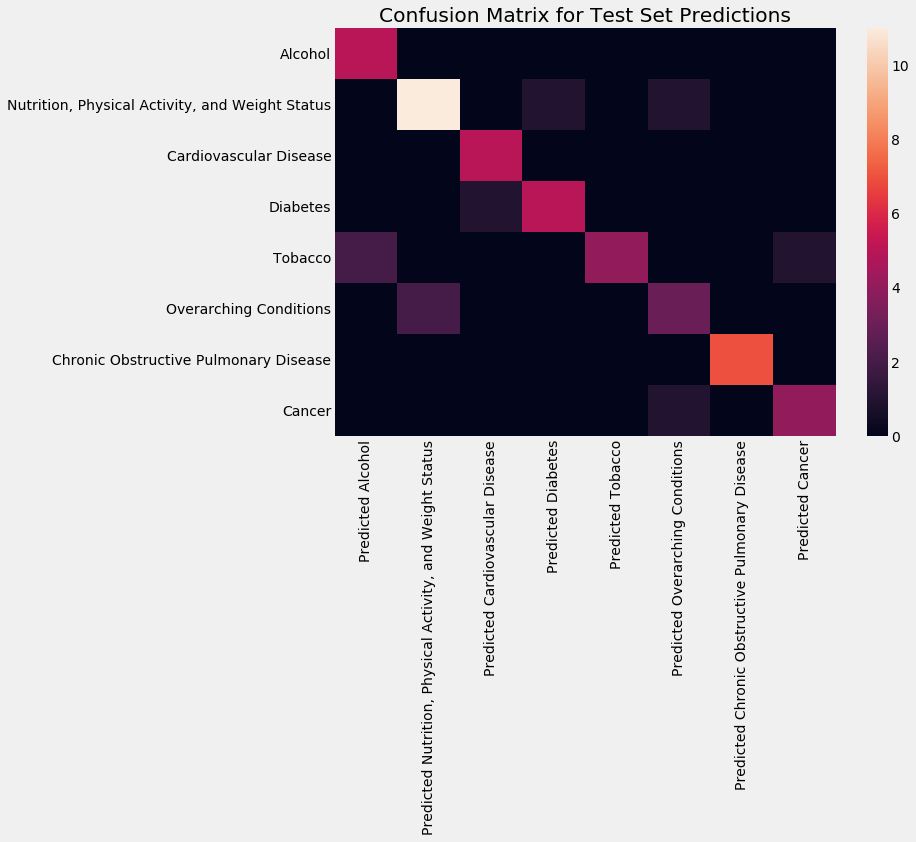

In [19]:
plt.figure(figsize=(10,7))
sns.heatmap(df_matrix)
plt.title("Confusion Matrix for Test Set Predictions")
plt.savefig('plots/LSTM_confusion_matrix.png')

In [20]:
model.save("models/LSTM.h5")
model.save_weights("models/LSTM_weights.h5")